# Aicraft recognition system

This is a model to recognize aircraft models based on pictures.

First we are going to write a custom dataset, since our data is not organized by folder/class as usual.

For this, I used the custom dataset tutorial available at:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Necessary imports

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

/home/santiago/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Function to annotation files on pandas dataframes

In [59]:
def load_annotation(filename, labelname):
    file_list = []

    with open(filename) as file:
        for line in file:
            line = line.split()
            imagefilename = line[0] + ".jpg"
            label = " ".join(line[1:])
            file_list.append([imagefilename, label])

    dataframe = pd.DataFrame(file_list)
    dataframe.columns = ["File", labelname]
    return dataframe

Now I load the annotation files

In [60]:
annotations_path = "../fgvc-aircraft-2013b/data"

manufacturers_train_file = os.path.join(annotations_path, "images_manufacturer_trainval.txt")
manufacturers_test_file = os.path.join(annotations_path, "images_manufacturer_test.txt")
family_train_file = os.path.join(annotations_path, "images_family_trainval.txt")
family_test_file = os.path.join(annotations_path, "images_family_test.txt")
variant_train_file = os.path.join(annotations_path, "images_variant_trainval.txt")
variant_test_file = os.path.join(annotations_path, "images_variant_test.txt")

manufacturers_train = load_annotation(manufacturers_train_file, "Manufacturer")
manufacturers_test = load_annotation(manufacturers_test_file, "Manufacturer")
family_train = load_annotation(family_train_file, "Family")
family_test = load_annotation(family_test_file, "Family")
variant_train = load_annotation(variant_train_file, "Variant")
variant_test = load_annotation(variant_test_file, "Variant")

Simple function to show images

C-130
747-300
BAE 146-300
E-195
Embraer Legacy 600
757-200
737-500
737-900
DHC-6
A320


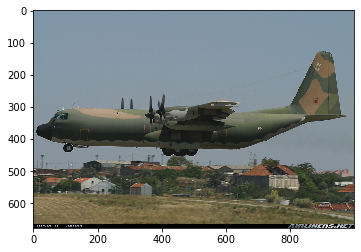

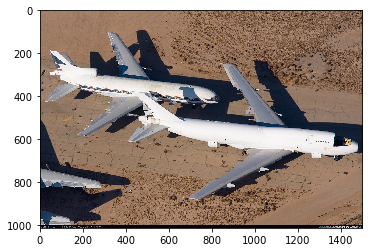

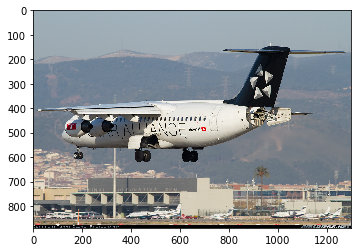

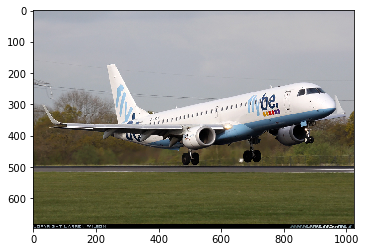

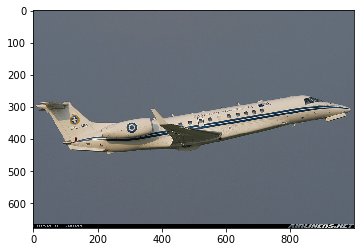

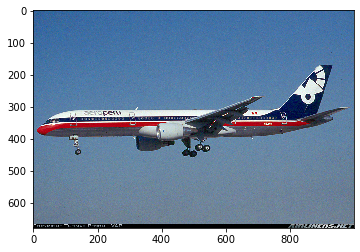

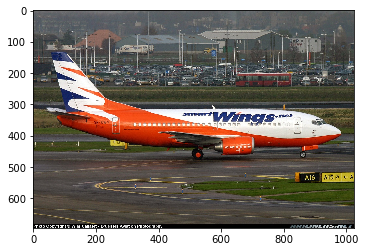

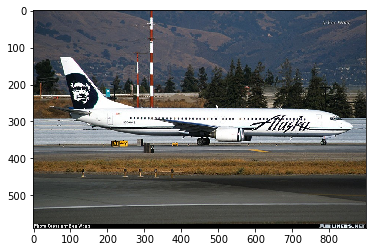

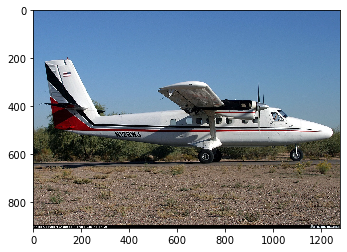

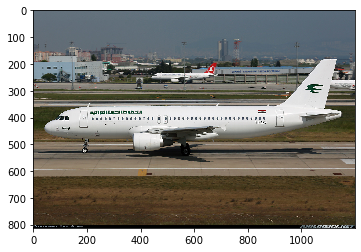

In [76]:
images_path = "../fgvc-aircraft-2013b/data/images"
sample = variant_train.sample(10)

for _,image in sample.iterrows():
    print(image["Variant"])
    image = io.imread(os.path.join(images_path, image["File"]))
    plt.figure()
    plt.imshow(image)